In [1]:
import pymc3 as pm

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
np.random.seed(123)

import scipy.stats as st
import scipy.special as ss

import theano.tensor as tt

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# generate Inverse Gaussian observations
mu = 1
lam = 3

y_wald = np.random.wald(mean=mu, scale=lam, size=5000)

y_norm = np.random.normal(loc=mu, scale=lam, size=5000)

range_x = 0.01
x_wald = np.arange(0, 10, range_x)
x_norm = np.arange(-15, 15, range_x)

upper = 1.5

## Normal distribution

In [3]:
def normal_pdf(x, mu, sigma):
    return np.exp(-((x-mu)**2)/(2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)

def normal_cdf(x, mu, sigma):
    return 0.5 * (1 + ss.erf((x-mu)/(sigma*np.sqrt(2))))

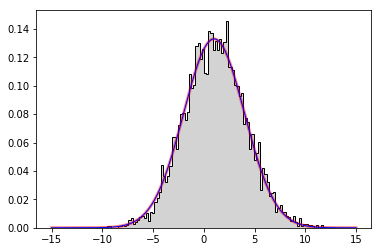

In [4]:
plt.hist(y_norm, bins=100, density=True, histtype='stepfilled', facecolor='lightgray', edgecolor='k');
plt.plot(x_norm, st.norm.pdf(x_norm, loc=mu, scale=lam), 'r-', alpha=0.5, lw=3);
plt.plot(x_norm, normal_pdf(x=x_norm, mu=mu, sigma=lam), 'b-', alpha=1, lw=1);

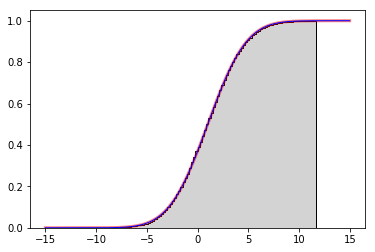

In [5]:
plt.hist(y_norm, bins=100, density=True, cumulative=True, histtype='stepfilled', facecolor='lightgray', edgecolor='k');
plt.plot(x_norm, st.norm.cdf(x_norm, loc=mu, scale=lam), 'r-', alpha=0.5, lw=3);
plt.plot(x_norm, normal_cdf(x=x_norm, mu=mu, sigma=lam), 'b-', alpha=1, lw=1);

## Truncated normal distribution

In [6]:
def normal_pdf_truncated(x, mu, sigma, upper):
    pdf = normal_pdf((x-mu)/sigma, 0, 1)
    Z = normal_cdf((upper-mu)/sigma, 0, 1)
    pdf /= (sigma * Z)
    
    return pdf

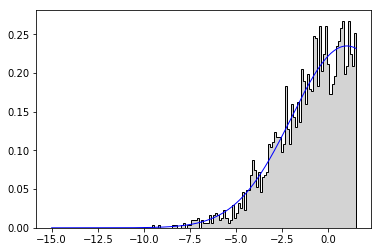

In [7]:
plt.hist(y_norm[y_norm<=upper], bins=100, density=True, histtype='stepfilled', facecolor='lightgray', edgecolor='k');
plt.plot(x_norm[x_norm<=upper], normal_pdf_truncated(x=x_norm[x_norm<=upper], mu=mu, sigma=lam, upper=upper), 'b-', alpha=1, lw=1);

In [8]:
def normal_cdf_truncated(x, mu, sigma, upper):
    cdf = normal_cdf((x-mu)/sigma, 0, 1)    
    Z = normal_cdf((upper-mu)/sigma, 0, 1)
    cdf /= Z
    
    return cdf

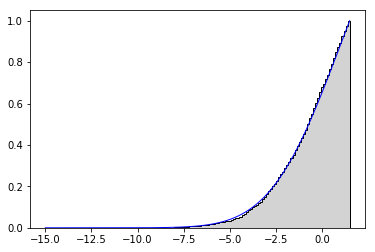

In [9]:
plt.hist(y_norm[y_norm<=upper], bins=100, density=True, cumulative=True, histtype='stepfilled', facecolor='lightgray', edgecolor='k');
plt.plot(x_norm[x_norm<=upper], normal_cdf_truncated(x=x_norm[x_norm<=upper], mu=mu, sigma=lam, upper=upper), 'b-', alpha=1, lw=1);

### Alternative version
Here I use the general method for truncating a distribution. We only need the pdf and cdf function

In [10]:
def normal_pdf_truncated_2(x, mu, sigma, upper):
    pdf = normal_pdf(x, mu, sigma)
    pdf /= normal_cdf(upper, mu=mu, sigma=sigma)
    
    return pdf

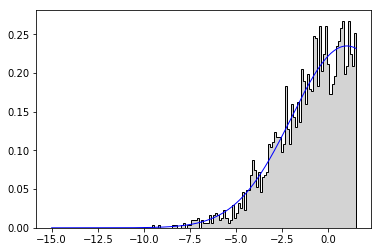

In [11]:
plt.hist(y_norm[y_norm<=upper], bins=100, density=True, histtype='stepfilled', facecolor='lightgray', edgecolor='k');
plt.plot(x_norm[x_norm<=upper], normal_pdf_truncated_2(x=x_norm[x_norm<=upper], mu=mu, sigma=lam, upper=upper), 'b-', alpha=1, lw=1);

## Inverse normal distribution

In [12]:
def inverse_gaussian_pdf(x, mu, lam):
    return np.sqrt(lam/(2*np.pi*x**3.0)) * np.exp((-lam*(x-mu)**2)/(2*x*mu**2))

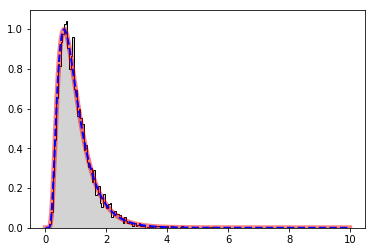

In [13]:
# Check if the defined function is working
plt.hist(y_wald, bins=100, density=True, histtype='stepfilled', facecolor='lightgray', edgecolor='k');

plt.plot(x_wald, st.invgauss.pdf(x_wald, mu=mu/lam, scale=lam), 'r-', alpha=0.5, lw=5)
plt.plot(x_wald, inverse_gaussian_pdf(x_wald, mu=mu, lam=lam), 'b--', alpha=1, lw=2)

In [14]:
def inverse_gaussian_cdf(x, mu, lam):
    arg1 = np.sqrt(lam/x) * (x/mu - 1)
    arg2 = -np.sqrt(lam/x) * (x/mu + 1)
    
    cdf = normal_cdf(arg1, 0, 1) # standard normal distribution
    cdf += np.exp(2*lam/mu) * normal_cdf(arg2, 0, 1)

    return cdf

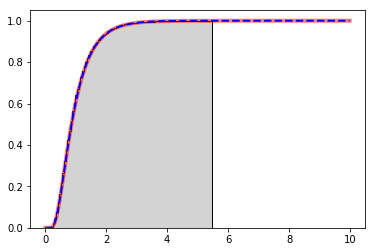

In [15]:
# Check if the defined function is working
plt.hist(y_wald, bins=100, density=True, cumulative=True, histtype='stepfilled', facecolor='lightgray', edgecolor='k');
plt.plot(x_wald, st.invgauss.cdf(x_wald, mu=mu/lam, scale=lam), 'r-', alpha=0.5, lw=4)
plt.plot(x_wald, inverse_gaussian_cdf(x_wald, mu=mu, lam=lam), 'b--', alpha=1, lw=2);

## Truncated inverse gaussian

In [16]:
def inverse_gaussian_pdf_truncated(x, mu, lam, upper):
    pdf = inverse_gaussian_pdf(x, mu, lam)    
    # renormalize
    pdf /= inverse_gaussian_cdf(upper, mu, lam)
    
    return pdf

(0, 6)

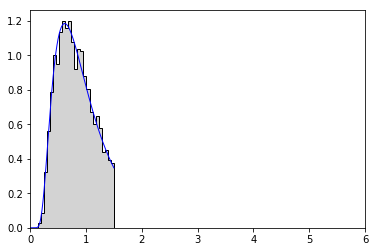

In [17]:
plt.hist(y_wald[y_wald<=upper], bins=25, density=True, histtype='stepfilled', facecolor='lightgray', edgecolor='k');
plt.plot(x_wald[x_wald<=upper], inverse_gaussian_pdf_truncated(x=x_wald[x_wald<=upper], mu=mu, lam=lam, upper=upper), 'b-', alpha=1, lw=1);
plt.xlim((0, 6))